In [5]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
import os, timeit

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline, make_pipeline

from utils.data_prep import *
from utils.visuals import *

pd.set_option("display.max_columns", None)
filterwarnings("ignore")

In [6]:
file_path = os.path.join("data", "Train_nyOWmfK.csv")
data = pd.read_csv(file_path, encoding="ISO-8859–1")

In [7]:
data.head(3)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0


# Happy Customer Bank Dataset

## Data exploration

The data was collected over a three-month period in 2015.

The dataset includes **26 columns** and **87 020 entries**.


It consists of:

* 13 numerical features:
    * 11 continous (Monthly_Income, Loan_Amount_Applied, Loan_Tenure_Applied, Existing_EMI, Loan_Amount_Submitted, Loan_Tenure_Submitted,
      Interest_Rate, Processing_Fee, EMI_Loan_Submitted, Var4, Var5)
    * 2 binary (LoggedIn, **Disbursed - target variable**)
* 13 object-type features:
    * 2 with dates (DOB, Lead_Creation_Date)
    * 7 categorical with multiple levels (ID, City, Employer_Name, Salary_Account, Var1, Var2, Source)
    * 4 binary categorical (Gender, Mobile_Verified, Filled_Form, Device_Type)
 
The ID column contains unique values for each sample and cannot be used for prediction. The LoggedIn column is for problem understanding purposes and cannot be used for prediction.

The meaning of Var1, Var2, Var4, Var5 and Source is unknown.

### Missing values

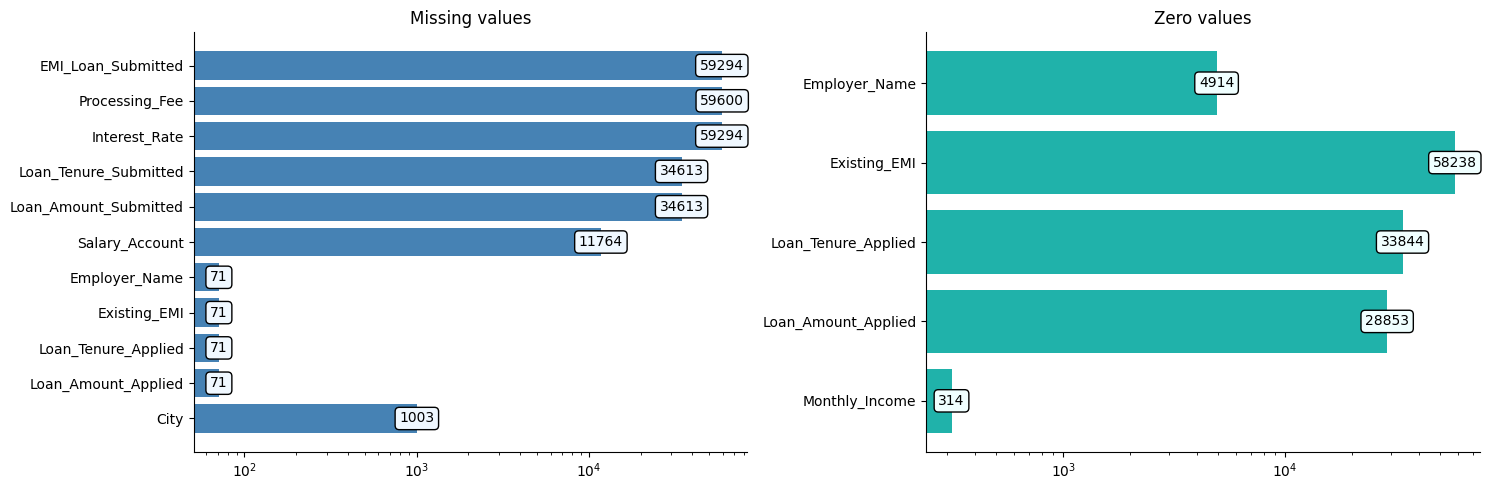

In [42]:
missings_plot(data)

#### There are many NaN and zero values in the dataset. The following assumptions were made:

* At least the majority of these values are not random.

* We have corresponding NaN values in columns sets:
  * 71 values in **Loan_Amount_Applied**, **Loan_Tenure_Applied**, **Existing_Emi**, **Employer_Name**:
    * These missing values may represent individuals who clicked on the bank's advertisement but did not take any further action or simply did not provide this information. Alternatively, they could be the same as the numerous zero values in these columns, where clients chose not to share this information.
    * Zeros might indicate a preliminary check to see if any loan can be processed.
    * Zeroes in the Existing_EMI column might, of course, indicate a lack of any outstanding debts 
  * 34,613 NaN values in **Loan_Amount_Submitted** and **Loan_Tenure_Submitted**:
    * These missing values may indicate individuals who applied for a loan but did not receive an offer from the bank, or in some cases, the application was initially accepted without any modificatio s.
  * 59,294 values in **Interest_Rate**, **Processing_Fee**, **EMI_Loan_Submitted**:
    * In addition to the aforementioned situations, the remaining 24,681 missing values.
    * These missing values can represent individuals who either completely accepted or completely rejected the initial terms.
    * On the other hand, the non-missing observations in these columns may represent individuals who negotiated loan terms and obtained additional, non-default offer parameters.

* The missing values in **City** column may indicate a lack of a permanent place of residence, but also carelessness in form completion.

* The missing values in **Salary_Account** column may indicate the absence of a bank account, but they could also result from carelessness during application filling or reluctance to share this information; notably, there aren't many positive loan disbursements for samples where the bank account information was not provided.

* Firstly, algorithms capable of handling missing values will be tested, and in subsequent steps, various methods of imputing them will be examined.
them will be examined.
d.

### Categorical variables

In [41]:
data.describe(include=['O'])

,ID,Gender,City,DOB,Lead_Creation_Date,Employer_Name,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
count,87020,87020,86017,87020,87020,86949,75256,87020,87020,87020,87020,87020,87020
unique,87020,2,697,11345,92,43567,57,2,19,2,2,7,30
top,ID000002C20,Male,Delhi,11-Nov-80,03-Jul-15,0,HDFC Bank,Y,HBXX,N,Web-browser,B,S122
freq,1,49848,12527,306,2315,4914,17695,56481,59294,67530,64316,37280,38567


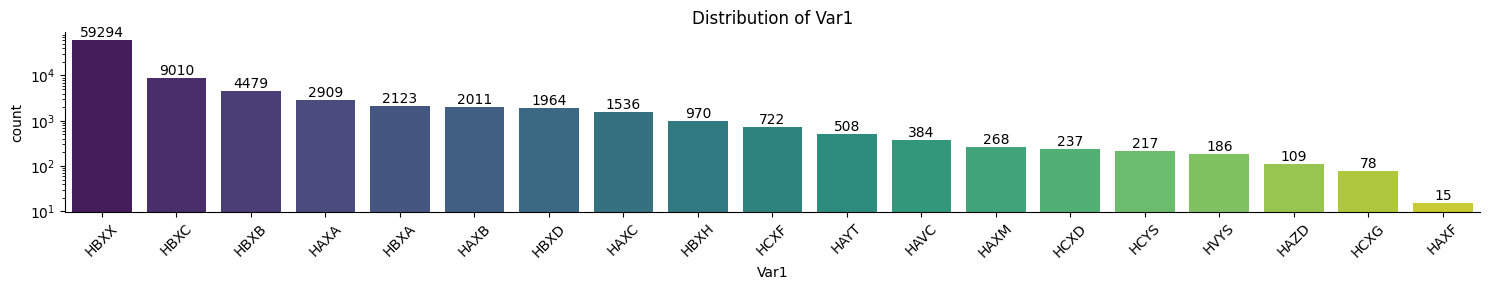

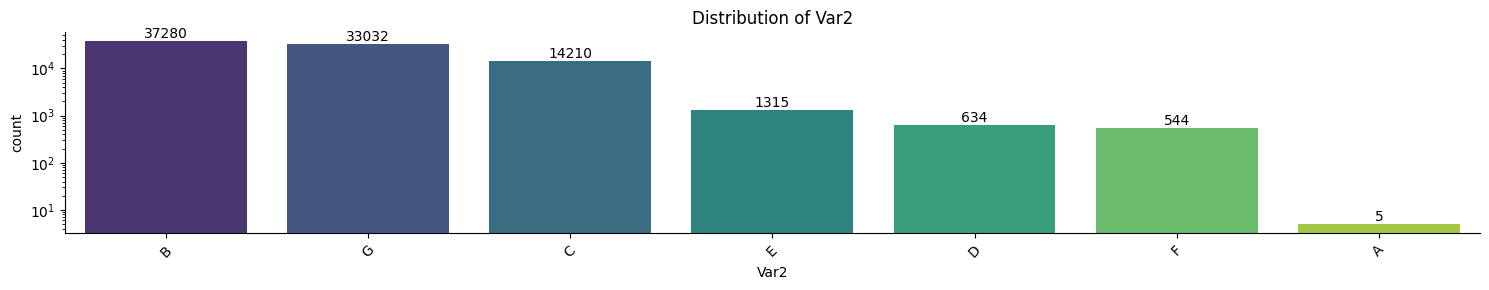

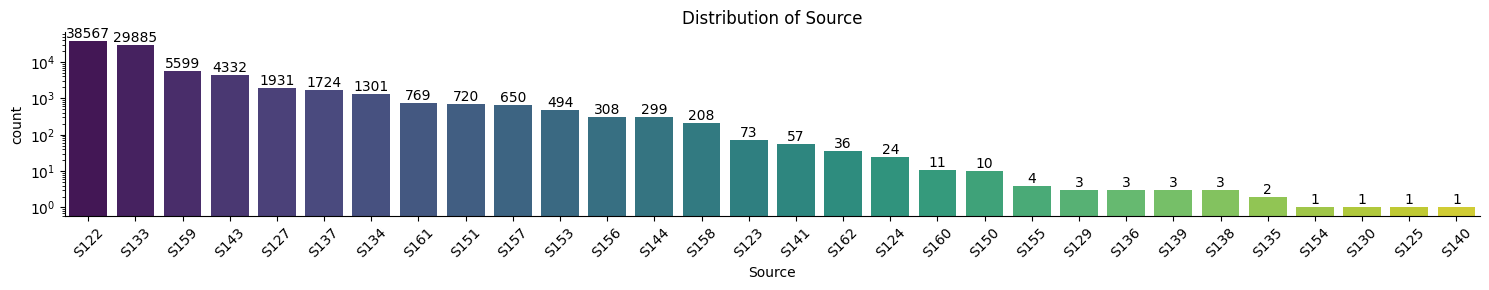

In [26]:
countplot("Var1", "Var2", "Source", data = data)

### Numerical variables

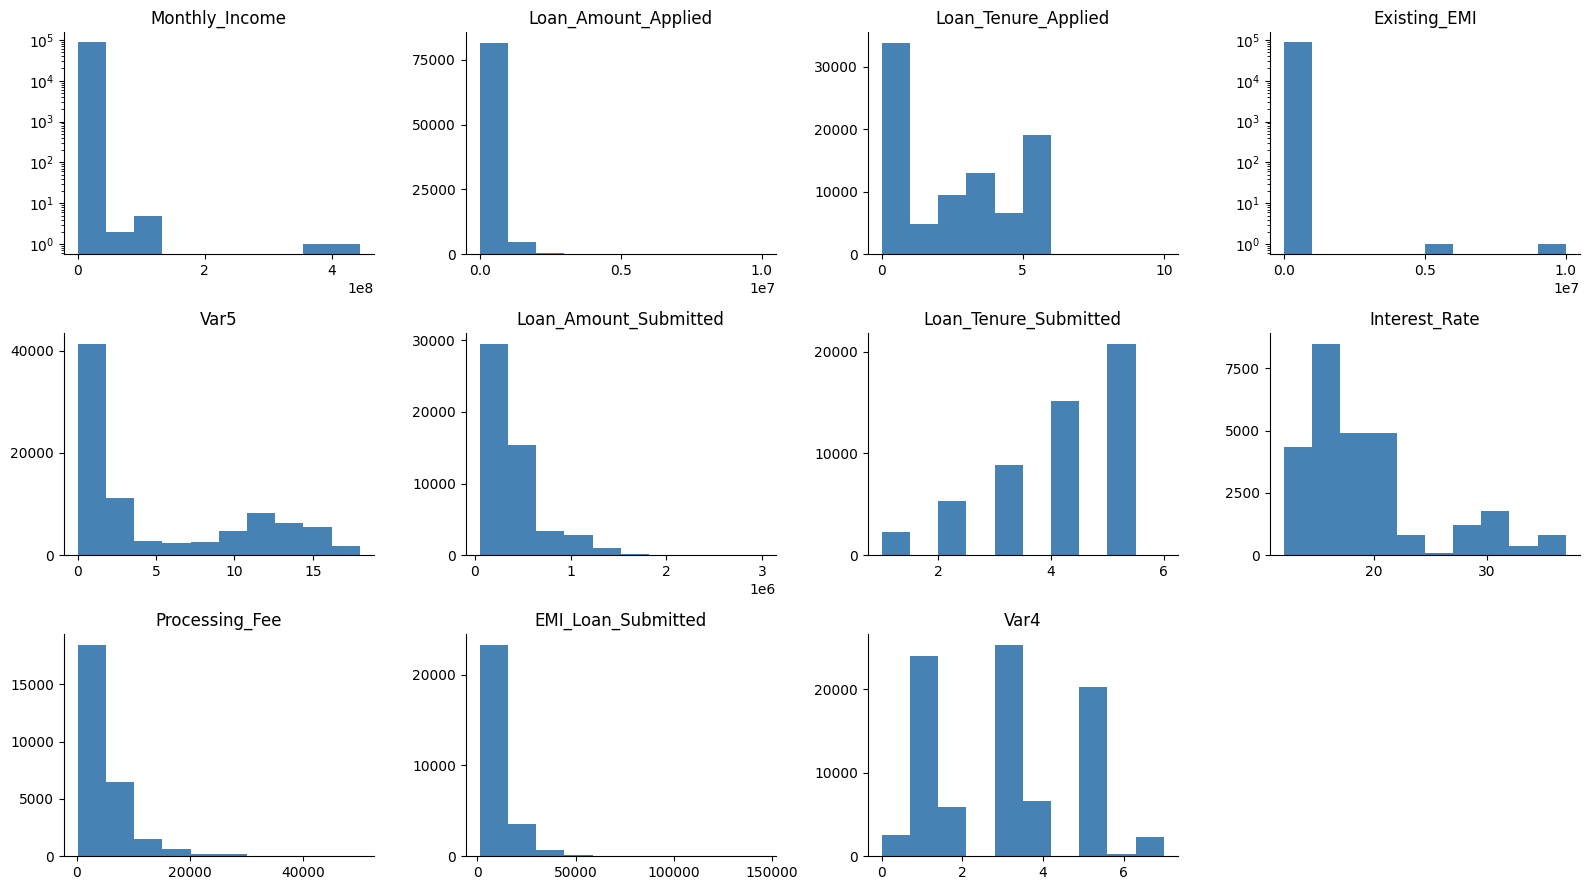

In [70]:
features_to_create_hist = [feature for feature in data.select_dtypes([int, float]).columns 
                           if data[feature].nunique() > 2]

grid_of_hists(3, 4, features_to_create_hist, data)

As seen above, the numerical features display different distributions and varying value ranges. It will be explored the option of applying transformations to bring these values closer to a normal distribution or standardize them, especially when using algorithms that require such transformations. However, these transformations are not necessary when using tree-based algorithms.

Additionally, certain variables (below) exhibit characteristics more typical of categorical features. It will be considered converting them into categorical variables, possibly agregating rare values. For the initial trials, however, they will remain unchanged.

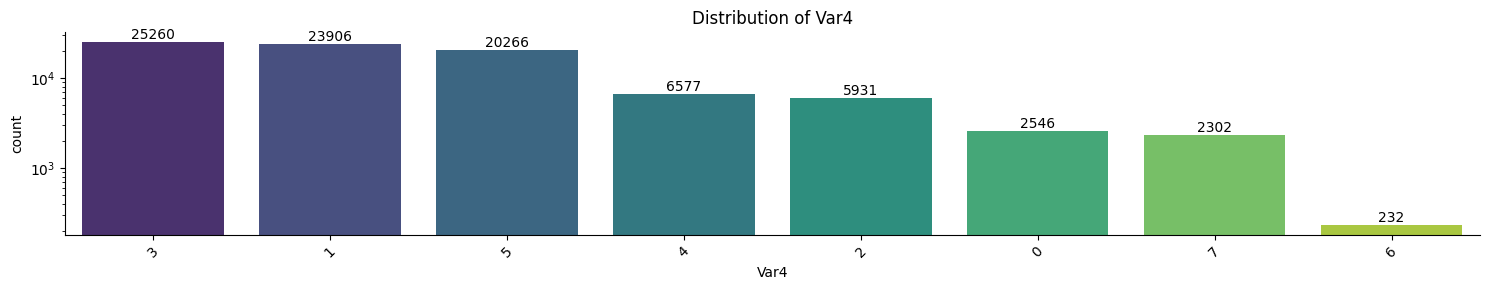

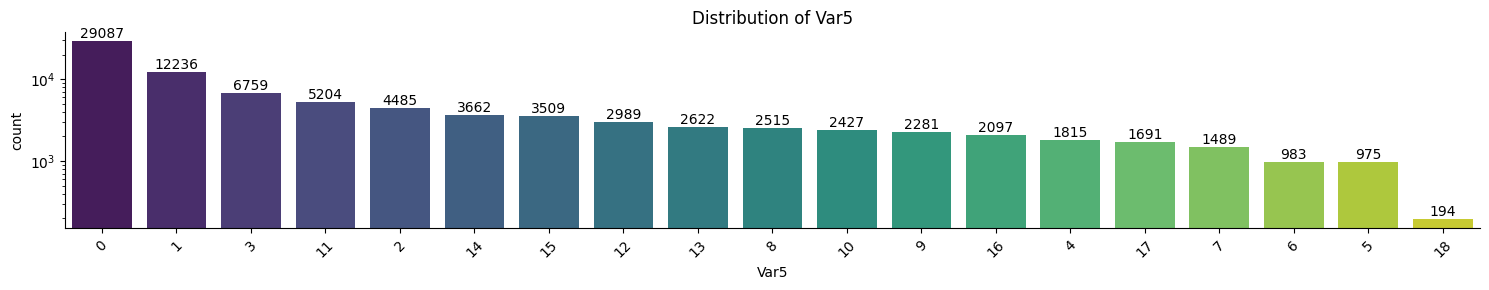

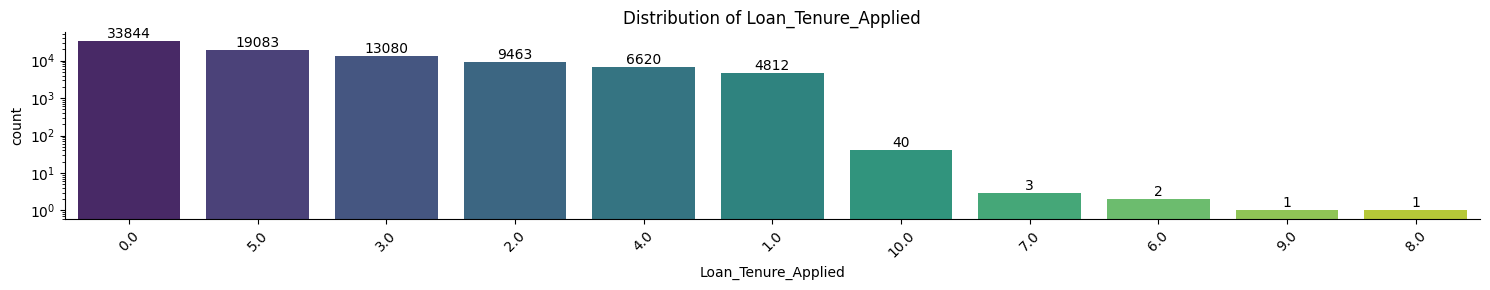

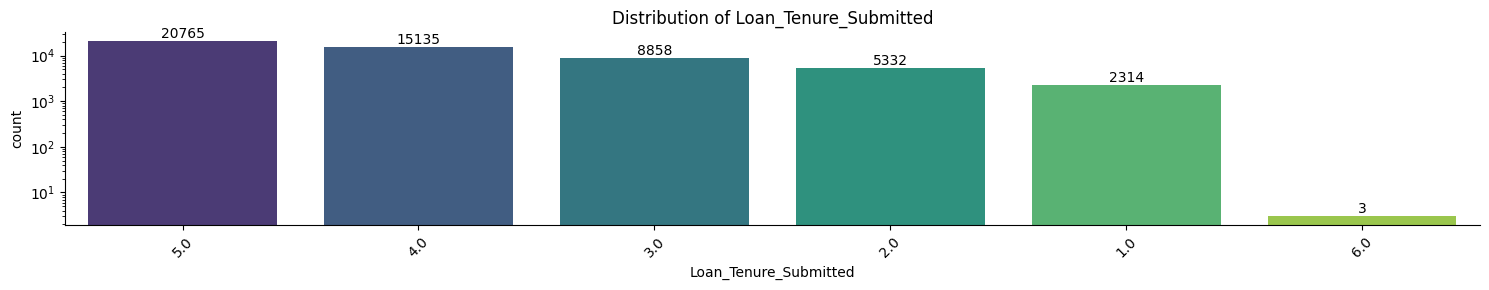

In [69]:
countplot("Var4", "Var5", "Loan_Tenure_Applied", "Loan_Tenure_Submitted", data = data)

# Initial model tests

## First data version **data_v1**

* **ID** column removed.

* **City** column cransformation: from 698 to 2 categories: Y/N ([cities with over 1 million residents and smaller](https://www.loomsolar.com/blogs/collections/list-of-cities-in-india)), missing values left unchanged. Renamed to **Is_Big_City**.

* **Employer_Name** column cransformation: from 43,568 to binary: 1 (provided) / 0 (not-provided - missing values, zeros and different numeric values). Renamed to **Employer_Provided**. The column also contained incorrect values - 50 different numerical values (for example, 54543543535, 2233, 12), which were also converted to 0, and an unknown number of incorrect names (such as "JSJSJSH," "ABC"), which are too difficult to distinguish from valid names.

* **Salary_Account** column cransformation: from 58 to binary: 1 (provided) / 0 (not-provided - missing values). Renamed to **Account_Provided**.

* **DOB** column cransformation: from date of birth to year of birth, which is analogous to using age, as the data was collected in the same year. Renamed to **Year_Of_Birth**.

* **Lead_Creation_Date** column cransformation: from date of creation to day of the year. Renamed to **Lead_Creation_Day**.

* **Var1, Var2, Source** - rare values aggregated as "Others".

* Numerical variiables and missing values left unchanged.

In [9]:
data_v1 = data_preparing_v1(data)

In [10]:
data_v1.head()

,Gender,Is_Big_City,Monthly_Income,Year_Of_Birth,Lead_Creation_Day,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Provided,Account_Provided,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,Female,Y,20000,78,135,300000.0,5.0,0.0,1,1,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,Male,Y,35000,85,124,200000.0,2.0,0.0,1,1,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,Male,N,22500,81,139,600000.0,4.0,0.0,1,1,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,Male,N,35000,87,129,1000000.0,5.0,0.0,1,1,Y,10,HBXX,920000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,Male,N,100000,84,140,500000.0,2.0,25000.0,1,1,Y,17,HBXX,500000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [11]:
X = data_v1.drop(["LoggedIn", "Disbursed"], axis = 1)
y = data_v1.Disbursed

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

In [12]:
X.shape

(87020, 23)

In [13]:
y.shape

(87020,)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

In [15]:
X_train.head()

,Gender,Is_Big_City,Monthly_Income,Year_Of_Birth,Lead_Creation_Day,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Provided,Account_Provided,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
26733,Female,Y,50000,76,151,1000000.0,5.0,0.0,1,1,N,15,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,3
81500,Female,Y,17475,88,208,200000.0,3.0,4732.0,1,1,N,1,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,3
81659,Female,N,52000,62,208,0.0,0.0,0.0,1,1,Y,13,HBXX,1050000.0,5.0,NaN,NaN,NaN,N,Mobile,G,S122,3
42803,Female,N,15000,92,169,30000.0,2.0,1500.0,1,1,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S143,1
28228,Female,Y,15000,90,153,200000.0,0.0,5000.0,1,1,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,1
